In [1]:
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py

from main.equilines import FieldLines
import main.plot_utils as pu
from main.utils import alpha_function

For a given output of a N-body simulation, make and save equipotential lines in XY plane for each time-step, at different values of z-coordinate and for different values of the potential

In [6]:
# Example data
data_path = "data/3b_positions_2.hdf5"

FLines = FieldLines(data_path)

lim = 2  # limits for the meshgrid
M = 300  # resolution of the meshgrid
FLines.define_meshgrid(lim, M)

t_idxs = np.arange(0, FLines.S, 1)  # time steps
zs = np.arange(2, -2, -0.15)  # z values for the field lines
potential_vals = np.linspace(-6, -3, 4)  # values of potentials for the field lines

# Computing and saving the equipotential lines. This make take a few minutes
savefold = "results/field_lines/"
FLines.save_field_lines(savefold, zs, t_idxs, potential_vals, filename="equilines")


Put things into a dictionary to plot aftwerards. May not be necessary to do it this way

In [2]:
loops = {}

with h5py.File('results/field_lines/equilines.hdf5', "r") as f:
    S = f["Header"].attrs["Nsteps"]
    zs = f["Header"].attrs["Zs"]
    vals = f["Header"].attrs["IsoValues"]
    NZ = len(zs)
    NV = len(vals)

    for t_idx in range(S):
        loops[f"{t_idx}"] = {}

        for val_idx in range(NV):
            loops[f"{t_idx}"][f"{val_idx}"] = {}
            ks = f[f"{t_idx:03d}_{val_idx:03d}_ks"]

            for k in ks:
                loops[f"{t_idx}"][f"{val_idx}"][f"{k}"] = []
                group = f[f"{t_idx:03d}_{val_idx:03d}_{k:03d}"]
                n_loops = len(group.keys())

                for l in range(n_loops):
                    loop = group[f"{t_idx:03d}_{val_idx:03d}_{k:03d}_{l:03d}"][()]
                    loops[f"{t_idx}"][f"{val_idx}"][f"{k}"].append(loop)

Create the animation

NameError: name 'FLines' is not defined

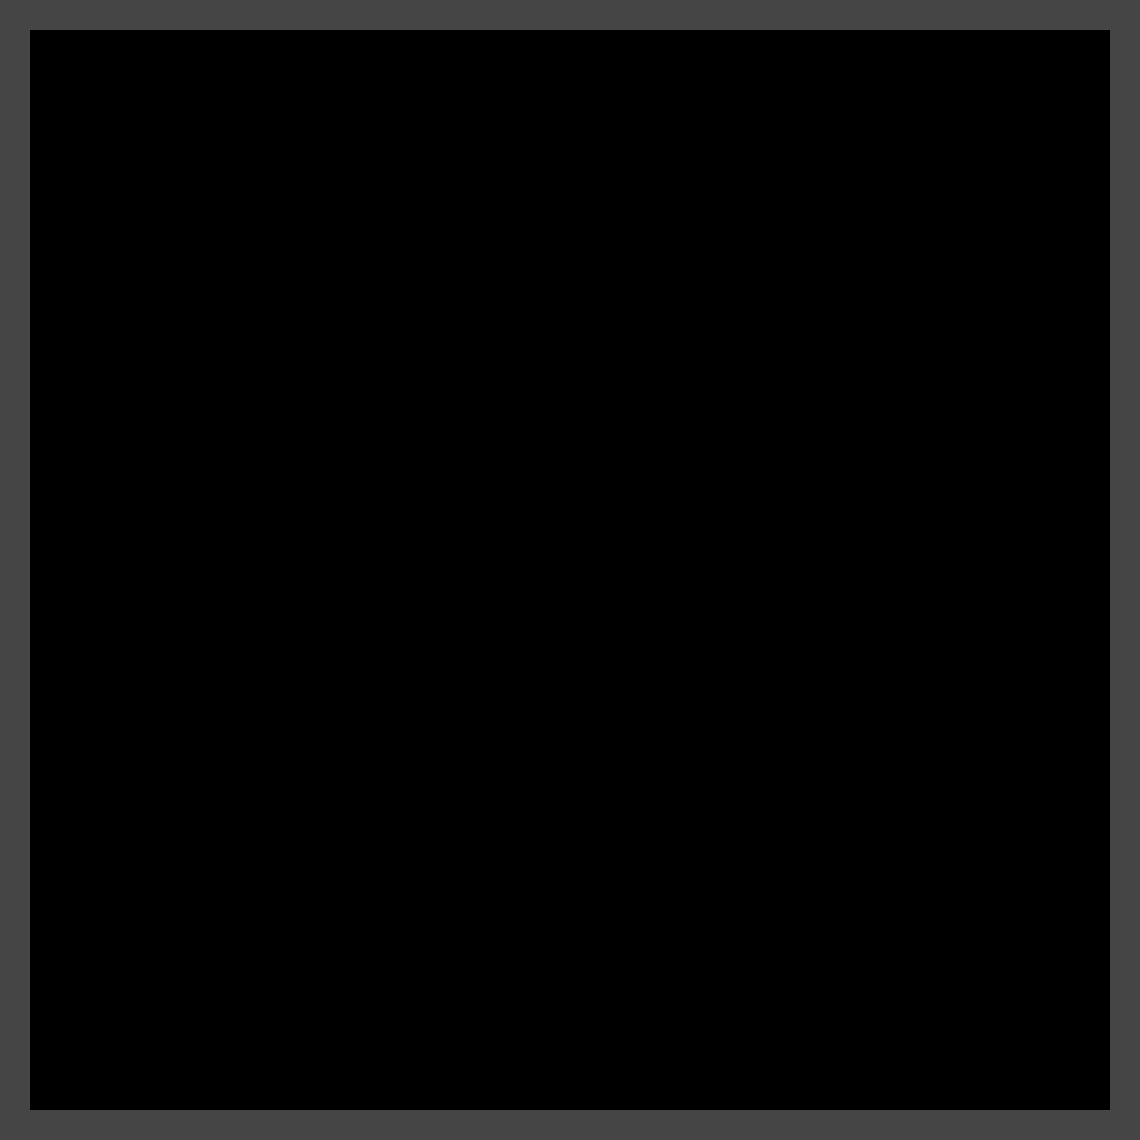

In [5]:
savefold = 'figures/frames/'
if not os.path.exists(savefold):
    os.makedirs(savefold)

Fig = pu.Figure3D(lims=1, polar=90, azimuth=25, fig_size=1403)
fs = Fig.fs
ax = Fig.ax


cmap = mpl.colormaps['cool_r']

t_idx = "0"
loops_at_t = loops[t_idx]

offsets = np.linspace(0.01, 0.1, NV)
diff_offset = offsets[1] - offsets[0]

i = 0

for i, t_idx in enumerate(list(loops.keys())[:]):
    loops_at_t = loops[t_idx]

    lines = []
    balls = []
    for p in range(3):
        x = FLines.positions[i, p, 0]
        y = FLines.positions[i, p, 1]
        z = FLines.positions[i, p, 2]

        r = 0.035
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        x_ = r * np.outer(np.cos(u), np.sin(v)) + x
        y_ = r * np.outer(np.sin(u), np.sin(v)) + y
        z_ = r * np.outer(np.ones(np.size(u)), np.cos(v)) + z

        ball = ax.plot_surface(x_, y_, z_, color='thistle', alpha=1)
        balls.append(ball)

    for j, val_idx in enumerate(list(loops_at_t.keys())[:]):
        loops_at_val = loops_at_t[val_idx]

        num_zs = len(list(loops_at_val.keys()))
        color = cmap(float(val_idx) / NV)

        offset = offsets[j]
        offsets_ = np.linspace(offset, offset + diff_offset, num_zs)

        for k, z_idx in enumerate(list(loops_at_val.keys())):
            loops_at_z = loops_at_val[z_idx]
            alpha = 1- k/num_zs

            
            alpha_arr = alpha_function(S, width=0.2, P=3, offset=offsets_[k])

            for l, loop in enumerate(loops_at_z):
                line, = ax.plot(loop[:, 0], loop[:, 1], loop[:,2], c=color, lw=0.1*fs, alpha=alpha_arr[i])
                lines.append(line)

    savepath = savefold + 'frame_{:04d}.jpg'.format(i)
    Fig.save(savepath)
    plt.close()

    for ball in balls:
        ball.remove()
    for line in lines:
        line.remove()

    print(f"{i+1}/{S}", end='\r')


Save as mp4 or gif

In [4]:
pu.frames_to_gif(savefold, title='animation', fps=30, extension='.jpg', quality=500)

# remove the frames
# shutil.rmtree(savefold)

Error during video conversion: Command 'ffmpeg -y -r 30 -i figures/frames/frame_%04d.jpg -c:v libx264 -profile:v high -crf 5 -preset slow -tune film -b:v 5000k -pix_fmt yuv420p -vf c:\Users\Pere\Documents\code\projects\equipotential_lines_animation\figures\animation.mp4' returned non-zero exit status 1.
